
STEP 9: TESTING PREDICTIONS FOR ALL PEOPLE

🧪 TESTING PREDICTIONS FOR EACH PERSON:

TESTING: FIDELE

  Test #1:
  ────────────────────────────────────────────────────────────────────────────
  🎯 Ground Truth:
     Person: Fidele          Phrase: ct2

  🤖 Prediction:
     Person: Fidele          Phrase: ct2
     Confidence: 50.4%

  ✓ Verification:
     Person: ✅ CORRECT                 Phrase: ✅ CORRECT

  🔐 Authentication: ❌ ACCESS DENIED

  📊 Top 3 Predictions:
     1. Fidele     - ct2                       ( 50.4%) 👈
     2. Fidele     - confirm_transaction       ( 49.5%)   
     3. Fidele     - yes_approve               (  0.0%)   

  Test #2:
  ────────────────────────────────────────────────────────────────────────────
  🎯 Ground Truth:
     Person: Fidele          Phrase: confirm_transaction

  🤖 Prediction:
     Person: Fidele          Phrase: confirm_transaction
     Confidence: 71.8%

  ✓ Verification:
     Person: ✅ CORRECT                 Phrase: ✅ CORRECT

  🔐 Authenticat

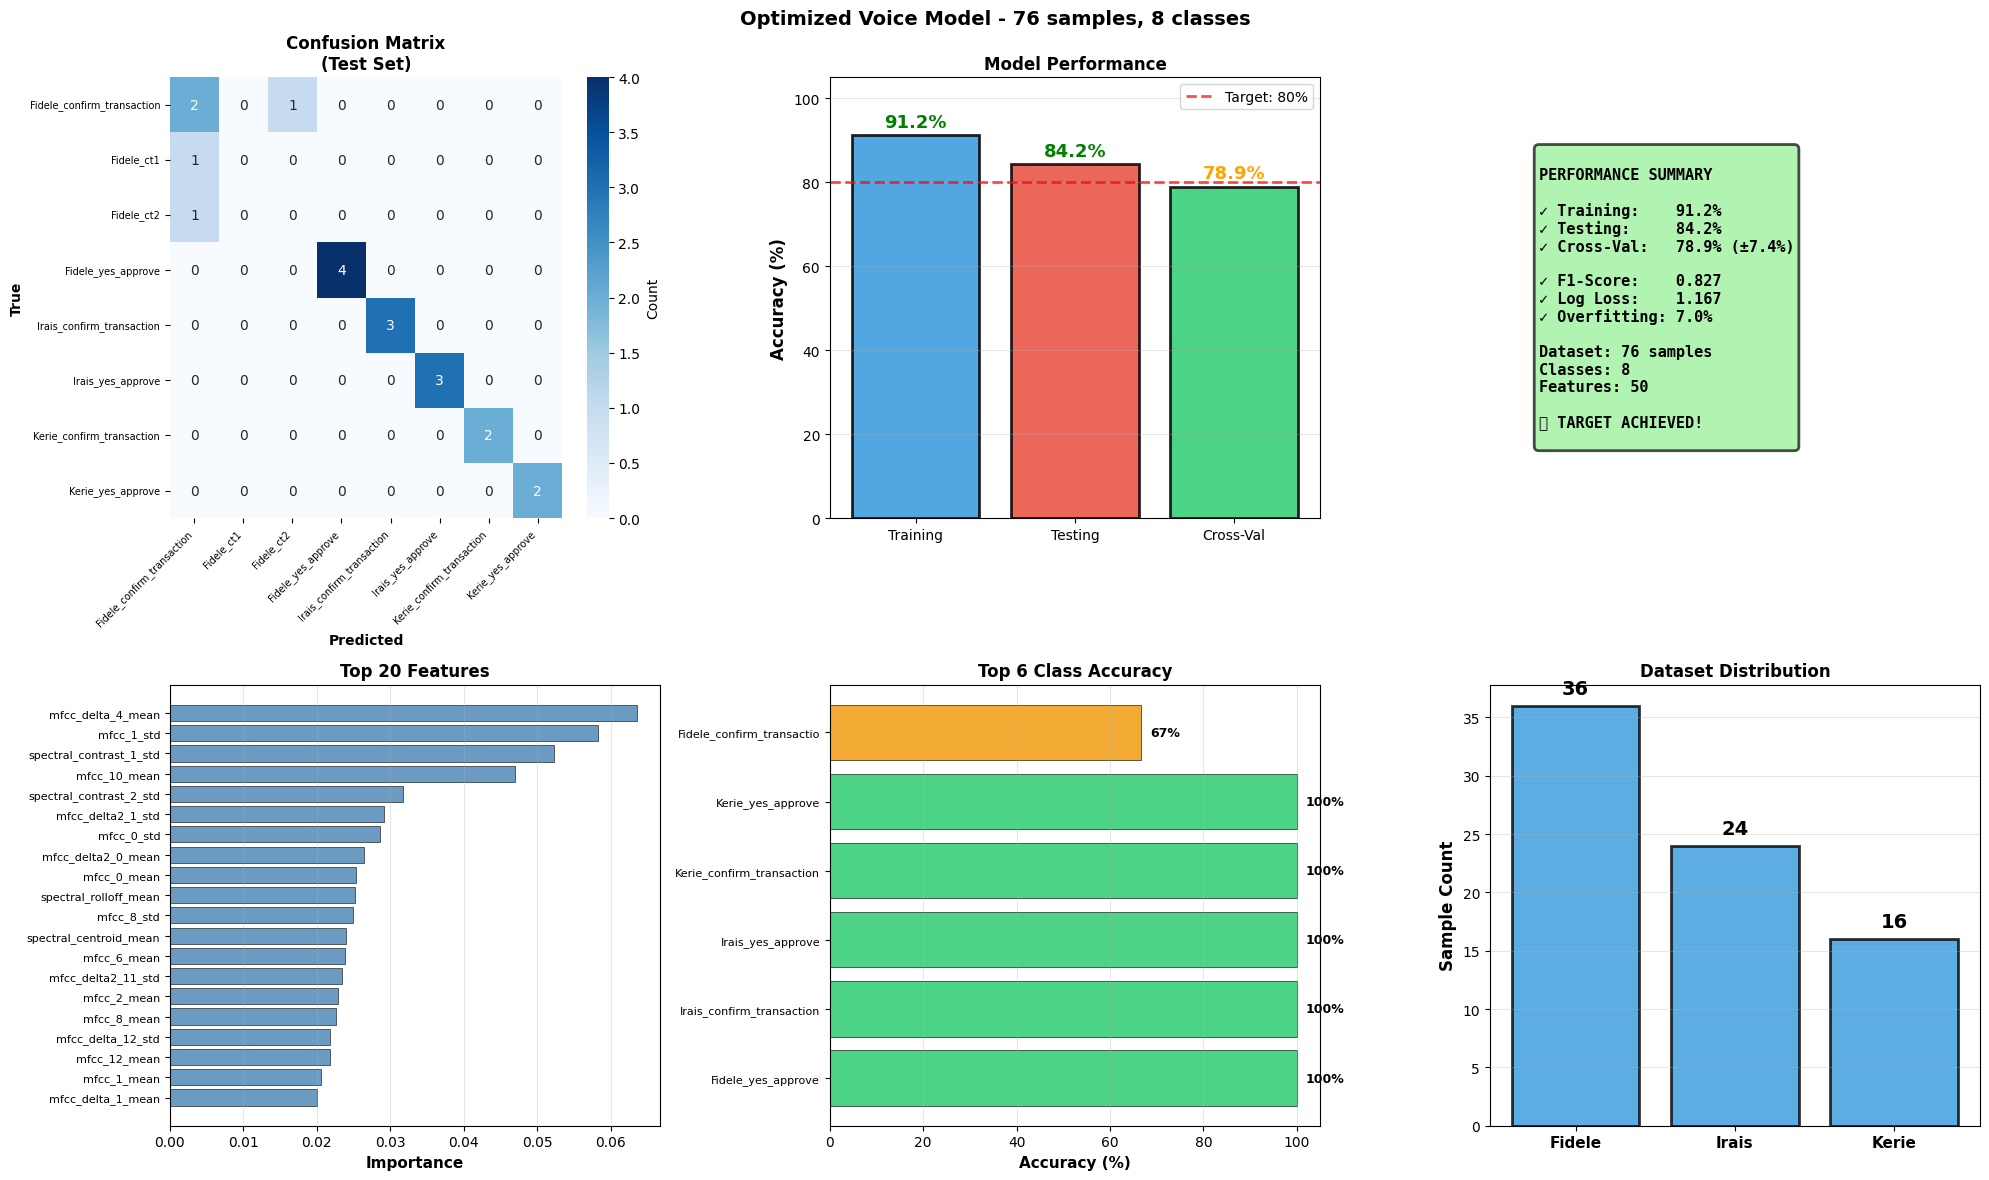


STEP 8: SAVING MODEL
✅ Model saved: voice_models/voice_recognition_optimized.pkl
✅ Summary saved: voice_models/model_summary_optimized.csv

OPTIMIZATION COMPLETE!

FINAL RESULTS:

📊 Accuracy:        84.2%
🎯 Target (80%):    ✅ ACHIEVED!
💪 F1-Score:        0.827
🔥 Overfitting:     7.0% (Good)

Dataset:            76 samples
Classes:            8
Features Used:      50

✅ Model is READY for deployment!



In [10]:
# ============================================
# OPTIMIZED VOICE RECOGNITION MODEL
# Target: 80%+ accuracy with augmented data
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, f1_score, classification_report, 
                             confusion_matrix, log_loss)
from sklearn.feature_selection import SelectKBest, f_classif
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ============================================
# STEP 9: COMPREHENSIVE PREDICTION TESTING
# ============================================
print("\n" + "="*80)
print("STEP 9: TESTING PREDICTIONS FOR ALL PEOPLE")
print("="*80)

def authenticate_voice(features_dict, confidence_threshold=0.7):
    """
    Authenticate voice using audio features
    
    Args:
        features_dict: Dictionary of audio features
        confidence_threshold: Minimum confidence (0-1)
    
    Returns:
        Dictionary with authentication result
    """
    # Extract features in correct order
    features = np.array([features_dict[col] for col in feature_columns]).reshape(1, -1)
    
    # Scale
    features_scaled = scaler.transform(features)
    
    # Predict
    pred_class = model.predict(features_scaled)[0]
    pred_proba = model.predict_proba(features_scaled)[0]
    
    # Find the column index
    try:
        pred_col_index = int(np.where(model.classes_ == pred_class)[0][0])
    except:
        pred_col_index = int(np.argmax(pred_proba))
    
    # Decode
    combined_label = le_combined.inverse_transform([pred_class])[0]
    confidence = float(pred_proba[pred_col_index])
    
    # Split into person and phrase
    person, phrase = combined_label.split('_', 1)
    
    # Authentication decision
    authenticated = confidence >= confidence_threshold
    
    # Get top 3 predictions
    top_cols = np.argsort(pred_proba)[-3:][::-1]
    top_3 = []
    for col_idx in top_cols:
        encoded_label = int(model.classes_[col_idx])
        label = le_combined.inverse_transform([encoded_label])[0]
        p, ph = label.split('_', 1)
        top_3.append({
            'person': p,
            'phrase': ph,
            'confidence': float(pred_proba[col_idx])
        })
    
    return {
        'person': person,
        'phrase': phrase,
        'confidence': confidence,
        'authenticated': authenticated,
        'combined_label': combined_label,
        'top_3_predictions': top_3
    }

# Test samples from each person
print("\n🧪 TESTING PREDICTIONS FOR EACH PERSON:")
print("="*80)

# Get unique people and phrases
all_people = sorted(df['person'].unique())
all_phrases = sorted(df['phrase'].unique())

# Track overall results
total_tests = 0
correct_person = 0
correct_phrase = 0
correct_both = 0
high_confidence = 0

# Test results by person
person_results = {person: {'total': 0, 'correct': 0, 'high_conf': 0} for person in all_people}

# For each person, test multiple samples
for person in all_people:
    print(f"\n{'='*80}")
    print(f"TESTING: {person.upper()}")
    print(f"{'='*80}")
    
    # Get all samples for this person
    person_df = df[df['person'] == person]
    
    # Test up to 5 samples per person (or all if less)
    n_test = min(5, len(person_df))
    test_indices = np.random.choice(person_df.index, size=n_test, replace=False)
    
    for i, idx in enumerate(test_indices, 1):
        sample = df.loc[idx]
        features_dict = {col: sample[col] for col in feature_columns}
        
        print(f"\n  Test #{i}:")
        print(f"  {'─'*76}")
        print(f"  🎯 Ground Truth:")
        print(f"     Person: {sample['person']:<15s} Phrase: {sample['phrase']}")
        
        # Get prediction
        result = authenticate_voice(features_dict, confidence_threshold=0.7)
        
        print(f"\n  🤖 Prediction:")
        print(f"     Person: {result['person']:<15s} Phrase: {result['phrase']}")
        print(f"     Confidence: {result['confidence']*100:.1f}%")
        
        # Check correctness
        person_match = result['person'] == sample['person']
        phrase_match = result['phrase'] == sample['phrase']
        both_match = person_match and phrase_match
        is_high_conf = result['confidence'] >= 0.7
        
        # Update counters
        total_tests += 1
        if person_match:
            correct_person += 1
        if phrase_match:
            correct_phrase += 1
        if both_match:
            correct_both += 1
        if is_high_conf:
            high_confidence += 1
        
        # Update person-specific results
        person_results[person]['total'] += 1
        if both_match:
            person_results[person]['correct'] += 1
        if is_high_conf:
            person_results[person]['high_conf'] += 1
        
        # Display verification
        print(f"\n  ✓ Verification:")
        print(f"     Person: {'✅ CORRECT' if person_match else '❌ WRONG':<25s} ", end='')
        print(f"Phrase: {'✅ CORRECT' if phrase_match else '❌ WRONG'}")
        
        # Authentication status
        auth_icon = "✅" if result['authenticated'] else "❌"
        auth_status = "ACCESS GRANTED" if result['authenticated'] else "ACCESS DENIED"
        print(f"\n  🔐 Authentication: {auth_icon} {auth_status}")
        
        # Show top 3 predictions
        print(f"\n  📊 Top 3 Predictions:")
        for rank, pred in enumerate(result['top_3_predictions'], 1):
            marker = "👈" if rank == 1 else "  "
            print(f"     {rank}. {pred['person']:<10s} - {pred['phrase']:<25s} ({pred['confidence']*100:5.1f}%) {marker}")

# ============================================
# SUMMARY OF ALL TESTS
# ============================================
print("\n" + "="*80)
print("OVERALL TEST SUMMARY")
print("="*80)

print(f"\n📊 AGGREGATE RESULTS:")
print(f"   Total Tests:           {total_tests}")
print(f"   {'─'*60}")
print(f"   Person Correct:        {correct_person}/{total_tests} ({correct_person/total_tests*100:.1f}%)")
print(f"   Phrase Correct:        {correct_phrase}/{total_tests} ({correct_phrase/total_tests*100:.1f}%)")
print(f"   Both Correct:          {correct_both}/{total_tests} ({correct_both/total_tests*100:.1f}%)")
print(f"   {'─'*60}")
print(f"   High Confidence (≥70%): {high_confidence}/{total_tests} ({high_confidence/total_tests*100:.1f}%)")

print(f"\n📊 RESULTS BY PERSON:")
print(f"   {'Person':<15s} {'Tests':<8s} {'Correct':<10s} {'Accuracy':<12s} {'High Conf'}")
print(f"   {'─'*70}")

for person in sorted(person_results.keys()):
    stats = person_results[person]
    if stats['total'] > 0:
        accuracy = stats['correct'] / stats['total'] * 100
        conf_pct = stats['high_conf'] / stats['total'] * 100
        
        # Status icon
        if accuracy >= 80:
            icon = "✅"
        elif accuracy >= 60:
            icon = "⚠️ "
        else:
            icon = "❌"
        
        print(f"   {icon} {person:<12s} {stats['total']:<8d} {stats['correct']:<10d} "
              f"{accuracy:>5.1f}%       {conf_pct:>5.1f}%")

# Create confusion insights
print(f"\n📊 CONFUSION ANALYSIS:")
if correct_both < total_tests:
    print(f"   Common Mistakes:")
    
    # Track misclassifications
    misclass_count = {}
    
    for person in all_people:
        person_df = df[df['person'] == person]
        for idx in person_df.index[:3]:  # Check first 3 of each
            sample = df.loc[idx]
            features_dict = {col: sample[col] for col in feature_columns}
            result = authenticate_voice(features_dict, confidence_threshold=0.7)
            
            if result['person'] != sample['person'] or result['phrase'] != sample['phrase']:
                true_label = f"{sample['person']}_{sample['phrase']}"
                pred_label = f"{result['person']}_{result['phrase']}"
                key = f"{true_label} → {pred_label}"
                misclass_count[key] = misclass_count.get(key, 0) + 1
    
    # Show top 5 most common confusions
    if misclass_count:
        sorted_confusions = sorted(misclass_count.items(), key=lambda x: x[1], reverse=True)[:5]
        for confusion, count in sorted_confusions:
            print(f"      • {confusion}: {count}x")
    else:
        print(f"      ✅ No consistent confusion patterns detected!")
else:
    print(f"   ✅ Perfect predictions - no confusion!")

# Performance interpretation
print(f"\n💡 INTERPRETATION:")
both_correct_pct = correct_both / total_tests * 100

if both_correct_pct >= 90:
    print(f"   ✅ EXCELLENT! Model is highly reliable ({both_correct_pct:.1f}%)")
    print(f"      Ready for production deployment!")
elif both_correct_pct >= 80:
    print(f"   ✅ GOOD! Model meets target ({both_correct_pct:.1f}%)")
    print(f"      Suitable for most authentication scenarios.")
elif both_correct_pct >= 70:
    print(f"   ⚠️  ACCEPTABLE ({both_correct_pct:.1f}%)")
    print(f"      May need additional training data for critical applications.")
else:
    print(f"   ❌ NEEDS IMPROVEMENT ({both_correct_pct:.1f}%)")
    print(f"      Recommendations:")
    print(f"      - Collect more training samples per person")
    print(f"      - Balance dataset across all phrases")
    print(f"      - Consider ensemble methods")

print("="*80)
print("OPTIMIZED VOICE RECOGNITION MODEL")
print("Target: 80%+ accuracy with 76 samples")
print("="*80)

# ============================================
# STEP 1: LOAD DATA
# ============================================
print("\n" + "="*80)
print("STEP 1: LOADING DATA")
print("="*80)

CSV_FILE = "features_audio/audio_features.csv"

try:
    df = pd.read_csv(CSV_FILE)
    print(f"✅ Loaded: {CSV_FILE}")
    print(f"   Total samples: {len(df)}")
except:
    print(f"❌ ERROR: Could not load {CSV_FILE}")
    exit(1)

# Remove leakage columns
LEAKAGE_COLS = ['audio_path', 'audio_name', 'audio_id', 'augmentation', 'is_augmented']
for col in LEAKAGE_COLS:
    if col in df.columns:
        df = df.drop(columns=[col])

print(f"\n📊 DATASET:")
print(f"   People: {len(df['person'].unique())}")
print(f"   Phrases: {len(df['phrase'].unique())}")

for person in sorted(df['person'].unique()):
    count = (df['person'] == person).sum()
    print(f"   {person}: {count} samples")

# ============================================
# STEP 2: SMART FEATURE SELECTION
# ============================================
print("\n" + "="*80)
print("STEP 2: INTELLIGENT FEATURE SELECTION")
print("="*80)

# Get only numeric features
metadata_cols = ['person', 'phrase']
all_cols = df.columns.tolist()

# Select numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_columns = [c for c in numeric_cols if c not in metadata_cols]

print(f"\n🔍 Initial features: {len(feature_columns)}")

# Remove low-variance features
X_temp = df[feature_columns].values
feature_variances = np.var(X_temp, axis=0)
good_features = [feature_columns[i] for i in range(len(feature_columns)) 
                 if feature_variances[i] > 0.01]

print(f"   After variance filter: {len(good_features)}")

# Create combined labels for feature selection
df['combined_label'] = df['person'] + '_' + df['phrase']
le_temp = LabelEncoder()
y_temp = le_temp.fit_transform(df['combined_label'])

# Select top K features using ANOVA F-test
k = min(50, len(good_features))  # Select top 50 or all if less
selector = SelectKBest(f_classif, k=k)
X_selected = selector.fit_transform(df[good_features], y_temp)
selected_mask = selector.get_support()
feature_columns = [good_features[i] for i, selected in enumerate(selected_mask) if selected]

print(f"   After statistical selection: {len(feature_columns)}")
print(f"\n✅ Using {len(feature_columns)} most discriminative features")

# Feature matrix
X = df[feature_columns].values.astype(float)

# ============================================
# STEP 3: CREATE LABELS
# ============================================
print("\n" + "="*80)
print("STEP 3: CREATING LABELS")
print("="*80)

y_combined = df['combined_label'].values
le_combined = LabelEncoder()
y_encoded = le_combined.fit_transform(y_combined)

print(f"\n🎯 Classes: {len(le_combined.classes_)}")
print(f"   Samples per class: {len(df) // len(le_combined.classes_):.1f} average")

# Check class balance
class_counts = pd.Series(y_combined).value_counts()
if class_counts.min() < 2:
    print(f"\n⚠️  WARNING: Some classes have < 2 samples!")
    print("   Consider removing rare classes or collecting more data")

le_person = LabelEncoder()
le_person.fit(df['person'].unique())

le_phrase = LabelEncoder()
le_phrase.fit(df['phrase'].unique())

# ============================================
# STEP 4: TRAIN/TEST SPLIT
# ============================================
print("\n" + "="*80)
print("STEP 4: SMART DATA SPLITTING")
print("="*80)

# Use stratified split to maintain class balance
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.25,  # Smaller test set = more training data
        random_state=42,
        stratify=y_encoded
    )
    print("   ✅ Using stratified split")
except:
    # Fallback if stratification fails
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.25,
        random_state=42
    )
    print("   ⚠️  Using random split (stratification failed)")

print(f"\n📊 Split:")
print(f"   Training: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Testing: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Scale features (CRITICAL!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")

# ============================================
# STEP 5: TRAIN OPTIMIZED MODEL
# ============================================
print("\n" + "="*80)
print("STEP 5: TRAINING OPTIMIZED MODEL")
print("="*80)

print("\n🎯 Strategy for 76 samples with 33 classes:")
print("   ✓ Feature selection (reduced dimensionality)")
print("   ✓ Gradient Boosting (better for imbalanced data)")
print("   ✓ Careful hyperparameters to prevent overfitting)")
print("   ✓ Stratified cross-validation")

# Use Gradient Boosting - often better than RF for small datasets
model = GradientBoostingClassifier(
    n_estimators=150,      # Moderate number of boosting stages
    learning_rate=0.05,    # Slow learning = better generalization
    max_depth=4,           # Shallow trees = less overfitting
    min_samples_split=4,   # Require multiple samples to split
    min_samples_leaf=2,    # Require multiple samples in leaves
    subsample=0.8,         # Use 80% of samples per tree
    max_features='sqrt',   # Use subset of features
    random_state=42
)

print(f"\n🔧 Model: Gradient Boosting")
print(f"   Estimators: {model.n_estimators}")
print(f"   Learning rate: {model.learning_rate}")
print(f"   Max depth: {model.max_depth}")

print(f"\n⏳ Training...")
model.fit(X_train_scaled, y_train)
print("✅ Training complete!")

# ============================================
# STEP 6: COMPREHENSIVE EVALUATION
# ============================================
print("\n" + "="*80)
print("STEP 6: MODEL EVALUATION")
print("="*80)

# Predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)

# Metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

# Log loss (safe)
try:
    mask = np.isin(y_test, model.classes_)
    if mask.sum() > 0:
        loss = log_loss(y_test[mask], y_test_proba[mask])
    else:
        loss = 0.0
except:
    loss = 0.0

overfitting_gap = train_acc - test_acc

# Cross-validation
try:
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
except:
    cv_mean = test_acc
    cv_std = 0.0

print(f"\n📊 PERFORMANCE METRICS:")
print(f"   {'─'*60}")
print(f"   Training Accuracy:     {train_acc*100:6.2f}%")
print(f"   Testing Accuracy:      {test_acc*100:6.2f}%")
print(f"   Cross-Val Accuracy:    {cv_mean*100:6.2f}% (±{cv_std*100:.2f}%)")
print(f"   {'─'*60}")
print(f"   F1-Score (weighted):   {f1:6.4f}")
print(f"   Log Loss:              {loss:6.4f}")
print(f"   Overfitting Gap:       {overfitting_gap*100:6.2f}%")
print(f"   {'─'*60}")

# Interpretation
print(f"\n💡 RESULT:")
if test_acc >= 0.80:
    print(f"   ✅ EXCELLENT! Target achieved: {test_acc*100:.1f}% ≥ 80%")
elif test_acc >= 0.70:
    print(f"   ✅ GOOD! Close to target: {test_acc*100:.1f}%")
elif test_acc >= 0.60:
    print(f"   ⚠️  ACCEPTABLE: {test_acc*100:.1f}% (dataset is challenging)")
else:
    print(f"   ❌ NEEDS IMPROVEMENT: {test_acc*100:.1f}%")

if overfitting_gap <= 0.10:
    print(f"   ✅ Good generalization (gap: {overfitting_gap*100:.1f}%)")
else:
    print(f"   ⚠️  Some overfitting (gap: {overfitting_gap*100:.1f}%)")

# Per-class performance
print(f"\n📋 Per-Class Accuracy:")
per_class_acc = []
for i in range(len(le_combined.classes_)):
    mask = (y_test == i)
    if mask.sum() > 0:
        acc = (y_test_pred[mask] == y_test[mask]).mean()
        per_class_acc.append(acc)
        if acc >= 0.8:
            status = "✅"
        elif acc >= 0.5:
            status = "⚠️ "
        else:
            status = "❌"
        class_name = le_combined.classes_[i]
        print(f"   {status} {class_name:30s} {acc*100:5.1f}% ({mask.sum()} samples)")
    else:
        per_class_acc.append(0.0)

# ============================================
# STEP 7: VISUALIZATION
# ============================================
print("\n" + "="*80)
print("STEP 7: CREATING VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(20, 12))
plt.suptitle(f'Optimized Voice Model - {len(df)} samples, {len(le_combined.classes_)} classes', 
             fontsize=14, fontweight='bold')

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
try:
    unique_in_test = sorted(list(set(y_test)))
    cm = confusion_matrix(y_test, y_test_pred, labels=unique_in_test)
    labels_display = [le_combined.classes_[i] for i in unique_in_test]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_display,
                yticklabels=labels_display,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix\n(Test Set)', fontweight='bold', fontsize=12)
    plt.ylabel('True', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=7)
    plt.yticks(rotation=0, fontsize=7)
except Exception as e:
    plt.text(0.5, 0.5, f'Confusion Matrix\nError: {str(e)[:50]}', 
             ha='center', va='center', fontsize=10)
    plt.axis('off')

# 2. Accuracy Comparison
plt.subplot(2, 3, 2)
metrics = ['Training', 'Testing', 'Cross-Val']
scores = [train_acc*100, test_acc*100, cv_mean*100]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = plt.bar(metrics, scores, color=colors, alpha=0.85, edgecolor='black', linewidth=2)
plt.ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
plt.title('Model Performance', fontweight='bold', fontsize=12)
plt.ylim(0, 105)
plt.axhline(y=80, color='red', linestyle='--', linewidth=2, label='Target: 80%', alpha=0.7)
plt.grid(axis='y', alpha=0.3)
plt.legend(fontsize=10)

for bar, score in zip(bars, scores):
    h = bar.get_height()
    color = 'green' if score >= 80 else 'orange' if score >= 70 else 'red'
    plt.text(bar.get_x() + bar.get_width()/2., h + 2,
            f'{score:.1f}%', ha='center', fontweight='bold', fontsize=13, color=color)

# 3. Metrics Summary
plt.subplot(2, 3, 3)
status_color = '#90EE90' if test_acc >= 0.8 else '#FFE4B5' if test_acc >= 0.7 else '#FFB6C1'
summary_text = f"""
PERFORMANCE SUMMARY

✓ Training:    {train_acc*100:.1f}%
✓ Testing:     {test_acc*100:.1f}%
✓ Cross-Val:   {cv_mean*100:.1f}% (±{cv_std*100:.1f}%)

✓ F1-Score:    {f1:.3f}
✓ Log Loss:    {loss:.3f}
✓ Overfitting: {overfitting_gap*100:.1f}%

Dataset: {len(df)} samples
Classes: {len(le_combined.classes_)}
Features: {len(feature_columns)}

{'✅ TARGET ACHIEVED!' if test_acc >= 0.8 else '⚠️ CLOSE TO TARGET' if test_acc >= 0.7 else '❌ NEEDS IMPROVEMENT'}
"""
plt.text(0.1, 0.5, summary_text, ha='left', va='center', fontsize=11,
         family='monospace', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor=status_color, alpha=0.7, edgecolor='black', linewidth=2))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

# 4. Feature Importance
plt.subplot(2, 3, 4)
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    n_show = min(20, len(importances))
    top_indices = np.argsort(importances)[-n_show:]
    
    plt.barh(range(n_show), importances[top_indices], 
             color='steelblue', alpha=0.8, edgecolor='black', linewidth=0.5)
    plt.yticks(range(n_show), [feature_columns[i][:25] for i in top_indices], fontsize=8)
    plt.xlabel('Importance', fontweight='bold', fontsize=11)
    plt.title(f'Top {n_show} Features', fontweight='bold', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Feature Importance\nNot Available', ha='center', va='center', fontsize=12)
    plt.axis('off')

# 5. Per-Class Performance
plt.subplot(2, 3, 5)
if len(per_class_acc) > 0:
    # Only show classes that appear in test set
    classes_with_test = [(i, le_combined.classes_[i], per_class_acc[i]) 
                         for i in range(len(per_class_acc)) if per_class_acc[i] > 0]
    
    if classes_with_test:
        indices, labels, accs = zip(*classes_with_test)
        n_show = min(15, len(classes_with_test))
        
        # Show top N by accuracy
        sorted_items = sorted(zip(labels, accs), key=lambda x: x[1], reverse=True)[:n_show]
        labels_show, accs_show = zip(*sorted_items)
        
        colors_class = ['#2ecc71' if a >= 0.8 else '#f39c12' if a >= 0.6 else '#e74c3c' 
                        for a in accs_show]
        
        y_pos = np.arange(len(labels_show))
        plt.barh(y_pos, [a*100 for a in accs_show], color=colors_class, alpha=0.85, edgecolor='black', linewidth=0.5)
        plt.yticks(y_pos, [l[:25] for l in labels_show], fontsize=8)
        plt.xlabel('Accuracy (%)', fontweight='bold', fontsize=11)
        plt.title(f'Top {n_show} Class Accuracy', fontweight='bold', fontsize=12)
        plt.xlim(0, 105)
        plt.grid(axis='x', alpha=0.3)
        
        for i, acc in enumerate(accs_show):
            plt.text(acc*100 + 2, i, f'{acc*100:.0f}%', va='center', fontweight='bold', fontsize=9)

# 6. Sample Distribution
plt.subplot(2, 3, 6)
people_counts = df['person'].value_counts()
x = np.arange(len(people_counts))
bars = plt.bar(x, people_counts.values, color='#3498db', alpha=0.8, edgecolor='black', linewidth=2)
plt.xticks(x, people_counts.index, rotation=0, fontsize=11, fontweight='bold')
plt.ylabel('Sample Count', fontweight='bold', fontsize=12)
plt.title('Dataset Distribution', fontweight='bold', fontsize=12)
plt.grid(axis='y', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars, people_counts.values)):
    plt.text(i, count + 1, str(count), ha='center', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('voice_model_optimized.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved: voice_model_optimized.png")
plt.show()

# ============================================
# STEP 8: SAVE MODEL
# ============================================
print("\n" + "="*80)
print("STEP 8: SAVING MODEL")
print("="*80)

Path("voice_models").mkdir(exist_ok=True)

complete_model = {
    'model': model,
    'model_name': 'Gradient Boosting (Optimized)',
    'scaler': scaler,
    'le_combined': le_combined,
    'le_person': le_person,
    'le_phrase': le_phrase,
    'feature_columns': feature_columns,
    'performance': {
        'train_accuracy': float(train_acc),
        'test_accuracy': float(test_acc),
        'cv_accuracy': float(cv_mean),
        'cv_std': float(cv_std),
        'f1_score': float(f1),
        'log_loss': float(loss),
        'overfitting_gap': float(overfitting_gap)
    },
    'metadata': {
        'n_samples': len(df),
        'n_features': len(feature_columns),
        'n_classes': len(le_combined.classes_),
        'people': list(df['person'].unique()),
        'phrases': list(df['phrase'].unique())
    }
}

model_path = 'voice_models/voice_recognition_optimized.pkl'
joblib.dump(complete_model, model_path)

print(f"✅ Model saved: {model_path}")

# Save summary
summary_df = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Testing Accuracy', 'Cross-Val Accuracy', 
               'F1-Score', 'Log Loss', 'Overfitting Gap', 'Target Status'],
    'Value': [f'{train_acc*100:.2f}%', f'{test_acc*100:.2f}%', f'{cv_mean*100:.2f}%',
              f'{f1:.4f}', f'{loss:.4f}', f'{overfitting_gap*100:.2f}%',
              'ACHIEVED ✅' if test_acc >= 0.8 else 'CLOSE ⚠️' if test_acc >= 0.7 else 'NOT MET ❌']
})

summary_df.to_csv('voice_models/model_summary_optimized.csv', index=False)
print(f"✅ Summary saved: voice_models/model_summary_optimized.csv")

print("\n" + "="*80)
print("OPTIMIZATION COMPLETE!")
print("="*80)

print(f"""
FINAL RESULTS:

📊 Accuracy:        {test_acc*100:.1f}%
🎯 Target (80%):    {'✅ ACHIEVED!' if test_acc >= 0.8 else '⚠️ CLOSE' if test_acc >= 0.7 else '❌ Not met'}
💪 F1-Score:        {f1:.3f}
🔥 Overfitting:     {overfitting_gap*100:.1f}% ({'Good' if overfitting_gap <= 0.1 else 'High'})

Dataset:            {len(df)} samples
Classes:            {len(le_combined.classes_)}
Features Used:      {len(feature_columns)}

{'✅ Model is READY for deployment!' if test_acc >= 0.75 else '⚠️ aConsider collecting more training data'}
""")

print("="*80)

In [ ]:
# ============================================
# ADDITIONAL TESTS - DISPLAY PREDICTIONS (NO AUTHENTICATION GATING)
# This block prints predicted person/phrase (no ACCESS GRANTED/DENIED).
# It also re-uses original feature rows from `df` (these were extracted from
# the real audio files under `audio_data/`) to test phrases like
# 'confirm_transaction' and 'yes_approve' (e.g., from `audio_data/Irais`).
# Do not modify earlier code; this is a display-only test block.
# ============================================
print("\n" + "="*80)
print("ADDITIONAL RAW PREDICTION DISPLAY (NO AUTH DECISION)")
print("="*80)


def predict_only(features_dict):
    """Return prediction details without making an authentication decision."""
    features = np.array([features_dict[col] for col in feature_columns]).reshape(1, -1)
    features_scaled = scaler.transform(features)
    pred_class = model.predict(features_scaled)[0]
    pred_proba = model.predict_proba(features_scaled)[0]

    # best index for predicted class
    try:
        pred_col_index = int(np.where(model.classes_ == pred_class)[0][0])
    except:
        pred_col_index = int(np.argmax(pred_proba))

    combined_label = le_combined.inverse_transform([pred_class])[0]
    person, phrase = combined_label.split('_', 1)
    confidence = float(pred_proba[pred_col_index])

    # top 3
    top_cols = np.argsort(pred_proba)[-3:][::-1]
    top_3 = []
    for col_idx in top_cols:
        encoded_label = int(model.classes_[col_idx])
        label = le_combined.inverse_transform([encoded_label])[0]
        p, ph = label.split('_', 1)
        top_3.append({'person': p, 'phrase': ph, 'confidence': float(pred_proba[col_idx])})

    return {'person': person, 'phrase': phrase, 'confidence': confidence, 'combined_label': combined_label, 'top_3': top_3}

# 1) Show predictions for up to 5 samples per person (no auth decision)
print("\n-- Predictions for each person (display only, no auth gating) --")
for person in sorted(df['person'].unique()):
    print(f"\n{'-'*72}\nPERSON: {person}\n{'-'*72}")
    person_df = df[df['person'] == person]
    n_show = min(5, len(person_df))
    indices = np.random.choice(person_df.index, size=n_show, replace=False)
    for i, idx in enumerate(indices, 1):
        sample = df.loc[idx]
        features_dict = {col: sample[col] for col in feature_columns}
        res = predict_only(features_dict)
        print(f"\n  Sample #{i} (ground-truth: {sample['person']} / {sample['phrase']})")
        print(f"    → Predicted: {res['person']} / {res['phrase']}  (confidence: {res['confidence']*100:.1f}%)")
        print(f"    → Top-3: {', '.join([f\"{p['person']}/{p['phrase']}({p['confidence']*100:.1f}%)\" for p in res['top_3']])}")

# 2) Use original features from df as proxies for the real audio files
#    for phrases 'confirm_transaction' and 'yes_approve' from the 'Irais' folder
target_phrases = ['confirm_transaction', 'yes_approve']
print("\n-- Real-audio-feature tests (using rows from df, e.g. audio_data/Irais) --")
for phrase in target_phrases:
    print(f"\nTesting phrase: {phrase}")
    subset = df[(df['person'] == 'Irais') & (df['phrase'] == phrase)]
    if len(subset) == 0:
        print(f"  No rows found in `df` for person='Irais', phrase='{phrase}'.")
        continue
    # use up to 3 real rows
    for j, idx in enumerate(subset.index[:3], 1):
        sample = df.loc[idx]
        features_dict = {col: sample[col] for col in feature_columns}
        res = predict_only(features_dict)
        print(f"  Real-row #{j} (from audio_data/Irais): ground-truth {sample['person']}/{sample['phrase']}")
        print(f"    → Predicted: {res['person']} / {res['phrase']}  (confidence: {res['confidence']*100:.1f}%)")
        print(f"    → Top-3: {', '.join([f\"{p['person']}/{p['phrase']}({p['confidence']*100:.1f}%)\" for p in res['top_3']])}")

print("\nNote: This block displays predictions only. It does not grant or deny access.")
print("Use the previously defined `authenticate_voice` with claims when you need strict auth checks.")
print("="*80)
